In [54]:
import pandas as pd
import os
ROOT = os.getcwd()
import seaborn as sns
import nltk
nltk.download('stopwords')
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import defaultdict
import contractions
import numpy as np

import torchtext
import textblob

import re

from tqdm import tqdm

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.metrics import accuracy_score

import pickle

import random


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TWEET140_PATH = os.path.join(ROOT, 'dataset', 'tweet140.csv')
assert os.path.exists(TWEET140_PATH), 'path to dataset not found'

In [3]:
#link: https://www.kaggle.com/code/abdoashraf90/twitter-sentiment-analysis
df = pd.read_csv(TWEET140_PATH, encoding="ISO-8859-1", names= ["target", "id", "date", "flag", "user", "text"])
print(df.shape)

df.drop(['id', 'date', 'flag', 'user'], axis = 1, inplace=True)
df.head()

(1600000, 6)


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Target has 2 values: 0 - negative, 4 - positive, o
# we want to convert 4 to 1 to make it conventional

df['target'][df['target'] == 4] = 1

C:\Users\nguye\AppData\Local\Temp\ipykernel_18640\3054085162.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'][df['target'] == 4] = 1


# EDA

target
0    800000
1    800000
Name: count, dtype: int64


<Axes: ylabel='count'>

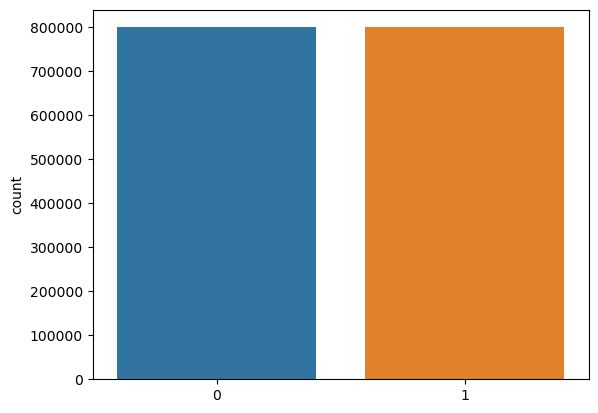

In [5]:
print(df['target'].value_counts())
sns.countplot(x = df['target'].values)

In [6]:
alltext = ' '.join(df['text'].values)
print(len(alltext))
print(alltext[:10])

120144177
@switchfoo


# Detect non-english words or rubbish

In [7]:
# words = alltext.split()

# lang = textblob.TextBlob()

# print(lang('something'))
# counter= Counter(words)

# with open('tweets140_words.txt', 'w') as file:
#     for k,v in counter.most_common():
#         file.write(f'{k}\n')


# Length and target correlation

In [8]:
df['length'] = df['text'].apply(lambda x: len(x))

In [9]:
df.head()

,target,text,length
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


In [10]:
print(df['target'].unique())

[0 1]


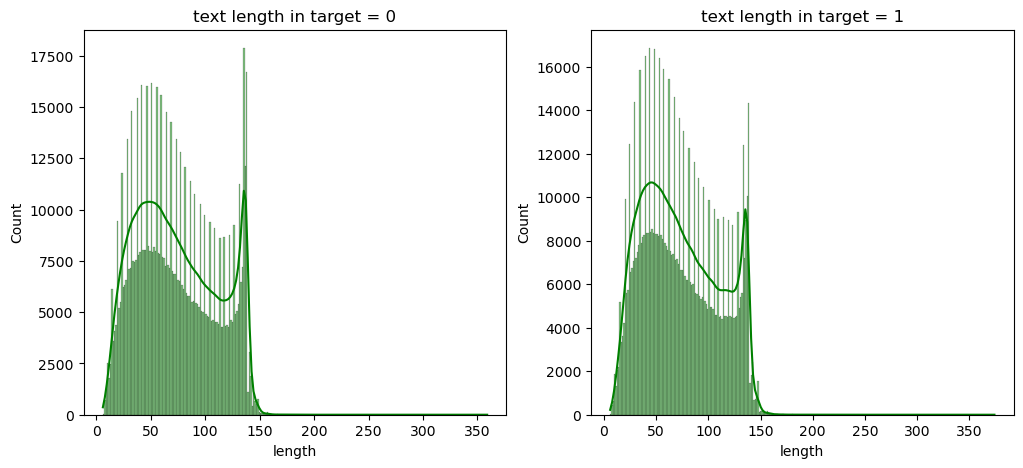

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
sns.histplot(data = df[df['target'] == 0], x = 'length', color = 'green', kde=True, ax = ax1)
ax1.set_title('text length in target = 0')
sns.histplot(data = df[df['target'] == 1], x = 'length', color = 'green', kde=True, ax = ax2)
ax2.set_title('text length in target = 1')
plt.show()

# clean text
- @something, starts with @
- https, web link wwww
- #hastag
- email
- non-latin symbols

In [20]:
def remove_urls(text):
    pattern =r"(http?\://|https?\://|www)\S+"
    return re.sub(pattern, ' ', text)

def remove_hashtags(text):
    pattern = r"#\S+"
    return re.sub(pattern, ' ', text)

def remove_mentions(text):
    pattern =r"(?:\@)\S+"
    return re.sub(pattern, ' ', text)

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text):
    return re.sub('[^A-Za-z]+', ' ', text)


def clean_text(text):
    text = text.lower()
    text = remove_urls(text)
    text = remove_hashtags(text)
    text = remove_mentions(text)
    text = expand_contractions(text)
    text = remove_special_characters(text)
    return text

def tokenize(text, tokenizer):
    return tokenizer(text)



In [ ]:
text = "link https://www.example.com and web http://subdomain.example.org. hashtag #something and mention @wooho"
print(remove_urls(text))
print(remove_hashtags(text))
print(remove_mentions(text))
print(clean_text(text))

text = "??you're a123., onderful men!!!"
print(clean_text(text))


In [82]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

df['text'] = df['text'].apply(clean_text)

df['tokens'] = df['text'].apply(lambda x: tokenize(x, tokenizer)) 

df['length'] = df['tokens'].apply(lambda x: len(x))
print('df after process ', df.shape)

# Drop text with len = 0
df = df.drop(df[df.length == 0].index)
print('df after dropping text with 0 len ', df.shape)

df = df.sample(frac = 1)

KeyboardInterrupt: 

In [22]:
df.head()

,target,text,length,tokens
0,0,a that is a bummer you shoulda got david carr...,17,"[a, that, is, a, bummer, you, shoulda, got, da..."
1,0,is upset that he cannot update his facebook by...,21,"[is, upset, that, he, cannot, update, his, fac..."
2,0,i dived many times for the ball managed to sa...,16,"[i, dived, many, times, for, the, ball, manage..."
3,0,my whole body feels itchy and like its on fire,10,"[my, whole, body, feels, itchy, and, like, its..."
4,0,no it is not behaving at all i am mad why am ...,22,"[no, it, is, not, behaving, at, all, i, am, ma..."


In [29]:
print(tokens[0])
print(type(tokens[0]))

['a', 'that', 'is', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd']
<class 'list'>


In [33]:
tokens = df['tokens'].values
labels = df['target'].values

print(tokens[:10])
print(len(tokens))
print(labels[:10])
print(len(labels))




[list(['a', 'that', 'is', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd'])
 list(['is', 'upset', 'that', 'he', 'cannot', 'update', 'his', 'facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also', 'blah'])
 list(['i', 'dived', 'many', 'times', 'for', 'the', 'ball', 'managed', 'to', 'save', 'the', 'rest', 'go', 'out', 'of', 'bounds'])
 list(['my', 'whole', 'body', 'feels', 'itchy', 'and', 'like', 'its', 'on', 'fire'])
 list(['no', 'it', 'is', 'not', 'behaving', 'at', 'all', 'i', 'am', 'mad', 'why', 'am', 'i', 'here', 'because', 'i', 'cannot', 'see', 'you', 'all', 'over', 'there'])
 list(['not', 'the', 'whole', 'crew']) list(['need', 'a', 'hug'])
 list(['hey', 'long', 'time', 'no', 'see', 'yes', 'rains', 'a', 'bit', 'only', 'a', 'bit', 'lol', 'i', 'am', 'fine', 'thanks', 'how', 'is', 'you'])
 list(['nope', 'they', 'did', 'not', 'have', 'it'])
 list(['que', 'me', 'muera'])]
1595958
[0 0 0 

# Building vocab

In [34]:
vocab = torchtext.vocab.build_vocab_from_iterator(tokens, min_freq = 5, specials = ['<unk>', '<pad>'])

In [35]:
print(vocab.get_itos()[:10])

['<unk>', '<pad>', 'i', 'to', 'the', 'a', 'is', 'you', 'my', 'it']


In [36]:
unk_index = vocab['<unk>']
print('unk index = ', unk_index)
pad_index = vocab['<pad>']
print('pad index = ', pad_index)
#set default index
vocab.set_default_index(unk_index)
print(vocab.lookup_indices(['something','is', 'not', 'okay', 'this should not be found']))

with open('vocab.txt', 'w') as file:
    for item in vocab.get_itos():
        file.write(item + '\n')

unk index =  0
pad index =  1
[190, 6, 11, 325, 0]


In [38]:
print(tokens[0])
print(vocab(tokens[0]))

['a', 'that', 'is', 'a', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'd']
[5, 17, 6, 5, 1132, 7, 3367, 43, 802, 9263, 15, 1806, 35, 3, 21, 9, 261]


In [39]:
def get_data(features, labels, vocab):
    X = []
    y = []
    valid_lens = []
    for i, feature in enumerate(tqdm((features))):
        valid_len = len(feature)
        if valid_len <= 0: 
            print('valid len = 0')
            continue
        X.append(torch.tensor(vocab(feature)))
        y.append(torch.tensor(labels[i]))
        valid_lens.append(torch.tensor(valid_len))

    return X,y,valid_lens

X,y,valid_lens = get_data(tokens, labels, vocab)


100%|██████████| 1595958/1595958 [00:44<00:00, 36031.49it/s]


In [40]:
X = pad_sequence(X, batch_first=True, padding_value = pad_index)
y = torch.tensor(y)
valid_lens = torch.tensor(valid_lens)

In [41]:
print('X shape = ', X.shape)
print('y shape = ', y.shape)
print('valid_lens shape = ', valid_lens.shape)

X shape =  torch.Size([1595958, 53])
y shape =  torch.Size([1595958])
valid_lens shape =  torch.Size([1595958])


In [42]:
print(valid_lens)

tensor([17, 21, 16,  ..., 11, 12,  1])


# Prep Dataset

In [43]:
class TweetDataset(Dataset):

    def __init__(self, X, y, valid_lens):
        assert torch.is_tensor(X) == True, 'X, y, and valid_lens must be torch.tensor'
        assert torch.is_tensor(y) == True, 'X, y, and valid_lens must be torch.tensor'
        assert torch.is_tensor(valid_lens) == True, 'X, y, and valid_lens must be torch.tensor'
        batch_size, seq_len = X.shape
        assert batch_size == y.shape[0] == len(valid_lens), 'X, y, and valid lens do not have the same 0 dim'

        self.X = X
        self.y = y 
        self.valid_lens = valid_lens
    
    def __getitem__(self, index) -> tuple:
        return self.X[index], self.y[index], self.valid_lens[index]
    
    def __len__(self):
        return len(self.X)

In [44]:
    
dataset = TweetDataset(X, y, valid_lens) 
print(len(dataset))

1595958


# Save/Load dataset
to save time from processing from scratch

In [45]:
TENSOR_DATA_PATH = os.path.join(ROOT, 'output')
if os.path.exists(TENSOR_DATA_PATH) == False: 
    os.makedirs(TENSOR_DATA_PATH)

#===== SAVE
# torch.save(dataset, os.path.join(TENSOR_DATA_PATH, 'tweet140.dataset.torch'))
# torch.save(vocab, os.path.join(TENSOR_DATA_PATH,'vocab.obj'))

#===== LOAD
dataset = torch.load(os.path.join(TENSOR_DATA_PATH, 'tweet140.dataset.torch'))
print('dataset len = ', len(dataset))
vocab = torch.load(os.path.join(TENSOR_DATA_PATH,'vocab.obj'))
print('vocab len = ', len(vocab))


In [46]:
# Split train valid test
train_ratio = 0.8
train_len = int(train_ratio * len(dataset))
val_len = test_len = (len(dataset) - train_len)//2
train_dataset, val_dataset, test_dataset = random_split(dataset,[train_len, val_len, test_len])


print('train dataset len = ', len(train_dataset))
print('val dataset len = ', len(val_dataset))
print('test datasel len = ', len(test_dataset))


train dataset len =  1276766
val dataset len =  159596
test datasel len =  159596


# Why we need valid lens and pack_padded_sequence

pack_padded_sequence prevents useless computations because of the padded sequence

https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch

In [ ]:
# sampleX, sampleY, 
# test = [torch.rand(random.randint(3,10)) for _ in range(10)] 
# valid_lens = [len(x) for x in test] 
# print(test)
# print(valid_lens)

# test = pad_sequence(test)
# print(test.shape)

# pack_test = pack_padded_sequence(test, valid_lens, batch_first=True, enforce_sorted=False)
# print(pack_test)

# LSTM model

In [48]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        vocab_size, 
        embedding_size,
        hidden_size,
        num_layers,
        # bidirectional,
        output_size, 
        pad_index,
        dropout = 0.5,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            # bidirectional=bidirectional,
            dropout = dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def count_params(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def load_pretrained_embedding(self, pretrained) -> None:
        #Loading glove
        self.embedding.weight.data = pretrained
    
    def forward(self, X, valid_lens, debug = False) -> torch.tensor:
        embedded = self.embedding(X)
        #using pack_padded_sequence to optimize computations in large datasets
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, valid_lens, batch_first=True, enforce_sorted=False
        )

        # print('pack embedded shape = ', packed_embedded)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        #because packed output will have different lengths
        # output, output_length = pack_padded_sequence(packed_output, valid_lens)
        #only use the last hidden layer for dense
        hidden = self.dropout(hidden[-1])

        y_pred = self.fc(hidden)
        if debug:
            print('original X shape = ', X.shape)
            print('valid lens shape = ', len(valid_lens))
            print('hidden shape = ', hidden.shape)
            print('last hidden shape = ', hidden.shape)
            print('output shape = ', y_pred.shape)
        return y_pred
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

cls = LSTMClassifier(1000, 30, 16, 2, 2, 3)        
cls.apply(init_weights)

sample_X = torch.randint(0,1000, (5, 10))
sample_valid_lens = [random.randint(3,10) for _ in range(5)]
print('sample X ', sample_X)
print('sample valid lens ', sample_valid_lens)

y_pred = cls(sample_X, sample_valid_lens)
print(y_pred)

sample X  tensor([[ 26, 623, 774, 182, 866, 795, 919, 540, 460,  71],
        [662, 562, 238, 154, 642, 621, 703, 328, 941, 188],
        [877, 866,  57, 384, 882, 839, 445, 138, 808, 632],
        [828, 824, 376, 501,  57, 937, 834, 902, 580, 721],
        [711, 829, 984, 153, 737,  77,  64, 510, 293, 675]])
sample valid lens  [8, 5, 3, 6, 9]
tensor([[ 0.0523,  0.0037],
        [-0.0954,  0.0253],
        [ 0.0024,  0.0398],
        [ 0.0505,  0.0006],
        [ 0.0519,  0.0097]], grad_fn=<AddmmBackward0>)


# Hyperparms

In [49]:
vocab_size = len(vocab)
print('vocab size = ', vocab_size)
#getting glove vectors
glove_vectors = torchtext.vocab.GloVe(name='6B')
pretrained_embedding = glove_vectors.get_vecs_by_tokens(vocab.get_itos())

#this muut match the GloVe pretrained dimension
embedding_size = 300
hidden_size = 300

#here we'll use CrossEntropyLoss instead of BCE
output_size = 2

batch_size = 100

num_layers = 2

dropout = 0.5

lr = 5e-4
batch_size = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

vocab size =  50809
device =  cuda


# Training loop

In [80]:
def get_accuracy(y_pred, y):
    batch_size = y_pred.shape[0]
    pred_classes = y_pred.argmax(-1)
    correct = torch.sum(pred_classes == y)
    return (correct/batch_size).item()


def train(model, dataloader, optimizer, criterion, device, epoch):

    model.train()
    scores = []
    losses = []

    loop = tqdm(dataloader)

    for X,y,valid_lens in loop:
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X, valid_lens)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #get accuracy
        score = get_accuracy(y_pred, y)


        scores.append(score)
        losses.append(loss.item())

        loop.set_description(f'ep = {epoch}, scores = {np.mean(scores):.2f}, loss = {np.mean(losses):.2f}')

    return np.mean(scores), np.mean(losses)

def evaluate(model, dataloader, criterion, device, epoch):
    model.eval()

    scores = []
    losses = []

    loop = tqdm(dataloader)

    with torch.no_grad():

        for X,y,valid_lens in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X, valid_lens)
            loss = criterion(y_pred, y)
            #get accuracy
            score = get_accuracy(y_pred, y)

            scores.append(score)
            losses.append(loss.item())

            loop.set_description(f'ep = {epoch}, scores = {np.mean(scores)}, loss = {np.mean(losses)}')
    
    return np.mean(scores), np.mean(losses)



In [81]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
print('train dataloader len = ', len(train_dataloader))
print('val dataloader len = ', len(val_dataloader))
print('test dataloader len = ', len(test_dataloader))

model = LSTMClassifier(
    vocab_size,
    embedding_size,
    hidden_size, 
    num_layers,
    output_size,
    pad_index
)

model.apply(init_weights)
model.load_pretrained_embedding(pretrained_embedding)

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

print('params = ', model.count_params())
history = defaultdict(list)

best_loss = 0


for epoch in range(10):

    train_score, train_loss = train(model, train_dataloader, optimizer, criterion, device, epoch)
    val_score, val_loss = evaluate(model, val_dataloader, criterion, device, epoch)
    test_score, test_loss = evaluate(model, test_dataloader, criterion, device, epoch)

    history['train_score'].append(train_score)
    history['train_loss'].append(train_loss)
    history['val_score'].append(val_score)
    history['val_loss'].append(val_loss)
    history['test_score'].append(test_score)
    history['test_loss'].append(test_loss)

    if best_loss > val_loss:
        best_loss = val_loss
        torch.save(model, os.path.join(ROOT, 'output', 'lstm.checkpoint.torch'))
        print('saved checkpoint')
    
    print(f'train: score={train_score}, loss={train_loss}')
    print(f'val: score={val_score}, loss={val_loss}')
    print(f'test: score={test_score}, loss={test_loss}')
        
fig, (ax1, ax2) = plt.subplots(2,1)
indices = list(range(len(history['train_score'])))
sns.lineplot(y = history['train_score'], x = indices, ax = ax1, label = 'train')
sns.lineplot(y = history['val_score'], x = indices, ax = ax1, color = 'green', label = 'valid')
sns.lineplot(y = history['test_score'], x = indices, ax = ax1, color = 'red', label = 'test')
ax1.set_title('Accuracy')

sns.lineplot(y = history['train_loss'], x = indices, ax = ax2, label = 'train')
sns.lineplot(y = history['val_loss'], x = indices, ax = ax2, color = 'green', label = 'valid')
sns.lineplot(y = history['test_loss'], x = indices, ax = ax2, color = 'red', label = 'test')
ax2.set_title('Loss')
plt.show()








train dataloader len =  9975
val dataloader len =  1247
test dataloader len =  1247
params =  16688102


ep = 0, scores = 0.80, loss = 0.44:  38%|███▊      | 3827/9975 [01:15<02:01, 50.44it/s]


KeyboardInterrupt: 

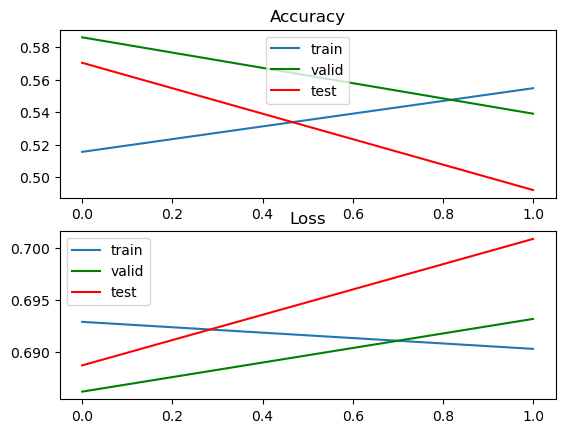

In [72]:
# fig, (ax1, ax2) = plt.subplots(2,1)
# indices = list(range(len(history['train_score'])))
# sns.lineplot(y = history['train_score'], x = indices, ax = ax1, label = 'train')
# sns.lineplot(y = history['val_score'], x = indices, ax = ax1, color = 'green', label = 'valid')
# sns.lineplot(y = history['test_score'], x = indices, ax = ax1, color = 'red', label = 'test')
# ax1.set_title('Accuracy')

# sns.lineplot(y = history['train_loss'], x = indices, ax = ax2, label = 'train')
# sns.lineplot(y = history['val_loss'], x = indices, ax = ax2, color = 'green', label = 'valid')
# sns.lineplot(y = history['test_loss'], x = indices, ax = ax2, color = 'red', label = 'test')
# ax2.set_title('Loss')
# plt.show()